In [ ]:
import os
root_dir = "/content/drive/My Drive/"

# choose where you want your project files to be saved
project_folder = "KTH/Deep Learning in DS (DD2424)/Amazing-Landscapes"
os.chdir(root_dir + project_folder)

In [ ]:
import sys
# !{sys.executable} -m pip install tensorflow
!{sys.executable} -m pip install tensorflow-addons
!{sys.executable} -m pip install -q tensorflow-io
!{sys.executable} -m pip install pyyaml

In [ ]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow_io as tfio
import tensorflow as tf
tfkl = tf.keras.layers
import importlib
import yaml
import numpy as np

from pathlib import Path
from tqdm import tqdm 
from PIL import Image

In [ ]:
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0   137k      0 --:--:-- --:--:-- --:--:--  137k
OK
79 packages can be upgraded. Run 'apt list --upgradable' to see them.
gcsfuse is already the newest version (0.35.0).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 79 not upgraded.


In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
!mkdir DataSets
!gcsfuse --implicit-dirs spade_dataset DataSets

mkdir: cannot create directory ‘DataSets’: File exists
2021/05/26 15:59:36.680354 Using mount point: /content/drive/My Drive/KTH/Deep Learning in DS (DD2424)/Amazing-Landscapes/DataSets
2021/05/26 15:59:36.686723 Opening GCS connection...
2021/05/26 15:59:36.884536 Mounting file system "spade_dataset"...
2021/05/26 15:59:36.885658 File system has been successfully mounted.


# Cityscape

In [ ]:
import data_processing.DataProcessing
importlib.reload(data_processing.DataProcessing)
import data_processing.DataProcessing as dp

config_dataset = yaml.load(Path("data_processing/config.yml").read_text(), Loader=yaml.SafeLoader)
config_dataset['img_height'] = 128

set_type = "train"
base_path = "DataSets/cityscape/processed_data"
reader = dp.DataReader(base_path, set_type, config_dataset)

reader.read_data_set()
data_set = reader.get_dataset()
type(data_set)

tensorflow.python.data.ops.dataset_ops.MapDataset

In [ ]:
from datetime import datetime
logdir = "logs/scalars/CityScape_" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, write_graph=True)


batch_size = 20
# checkpoint_path = "DataSets/checkpoints/cityscape_128_256-{epoch:02d}.ckpt"
checkpoint_path = "DataSets/checkpoints/cityscape/cityscape_128_256-150"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=False, verbose=1,  save_freq='epoch', period=20)

In [ ]:
import model.encoder
import model.SpadeGenerator
import model.model
import model.Discriminator
import model.vgg19
importlib.reload(model.encoder)
importlib.reload(model.SpadeGenerator)
importlib.reload(model.Discriminator)
importlib.reload(model.vgg19)
importlib.reload(model.model)


from model.encoder import Encoder, Sampler
from model.SpadeGenerator import SpadeGenerator
from model.Discriminator import Discriminator
import model.Discriminator as dc
from model.model import Model, LearningRateReducer

config = yaml.load(Path("config.yml").read_text(), Loader=yaml.SafeLoader)
config['img_height'] = 128

lr = 0.0004
g_lr = lr / 2
d_lr = lr * 2
decay_epoch = 120
total_epochs = 150
lr_reducer = LearningRateReducer(decay_epoch = decay_epoch, total_epochs = total_epochs)

adam_d_optimizer = tf.keras.optimizers.Adam(learning_rate=d_lr, beta_1 = 0, beta_2=0.9)
adam_g_optimizer = tf.keras.optimizers.Adam(learning_rate=g_lr, beta_1 = 0, beta_2=0.9)


Cityscape = Model(config=config)
Cityscape.compile(d_optimizer = adam_d_optimizer, g_optimizer= adam_g_optimizer)
Cityscape.fit(data_set.shuffle(buffer_size = 3000).batch(batch_size), epochs=total_epochs, callbacks=[tensorboard_callback, lr_reducer, cp_callback])

80142336/80134624 [==============================] - 1s 0us/step


In [ ]:
checkpoint_path = "DataSets/checkpoints/CelebAMask/new_cityscape-1341"
Cityscape.load_weights(checkpoint_path)

## Generate Some Examples

IMAGE!


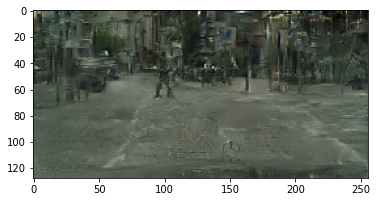

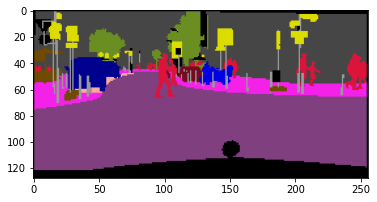

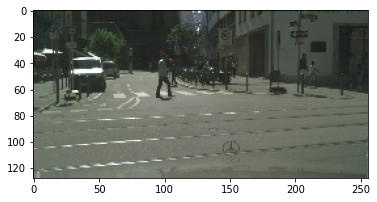

In [ ]:
for image in data_set.batch(200).take(1):
    mask_batch = image['img_masked']
    img_batch = image['img_original']
    label_batch = image['label']

test_mask = tf.expand_dims(mask_batch[90], axis=0)
test_image = tf.expand_dims(img_batch[90], axis=0)

out_mu, out_var = Cityscape.encoder(test_image)
z_noise_style = Cityscape.sampler((out_mu, out_var), train=False)
generated_image = Cityscape.generator(test_mask, z_noise = z_noise_style)


generated_image = ((generated_image[0].numpy() + 1) * 127.5).astype(int)
plt.imshow(generated_image)
plt.show()

test_mask_ = ((test_mask[0].numpy() + 1) * 127.5).astype(int)
plt.imshow(test_mask_)
plt.show()

test_image_ = ((test_image[0].numpy() + 1) * 127.5).astype(int)
plt.imshow(test_image_)
plt.show()

## Generate Images overr Epochs

In [ ]:
for i in range(15, 181, 15):
  checkpoint_path = f"DataSets/checkpoints/cityscape/new_cityscape_128_256-{i}"
  test_model.load_weights(checkpoint_path)

  out_mu, out_var = test_model.encoder(img_batch)
  z_noise_style = test_model.sampler((out_mu, out_var))
  generated_images = test_model.generator(mask_batch, z_noise = z_noise_style)
  
  for generated_image, label in zip(generated_images, label_batch):
        omg_work = np.array(((generated_image.numpy() + 1) * 127.5).astype(int), dtype="uint8")
        path =f"DataSets/generated_images/cityscape/progress/epoch_{i}__{label.numpy().decode('utf-8')}.jpeg"
        plt.imsave(path, omg_work)

## Inference (VAL)

In [ ]:
set_type = "train"
base_path = "DataSets/cityscape/processed_data"
reader = dp.DataReader(base_path, set_type, config_dataset)
reader.read_data_set()
data_set = reader.get_dataset()

### Generate over all Val dataset

In [ ]:
for image in data_set.batch(100).take(30):
    mask_batch = image['img_masked']
    img_batch = image['img_original']
    label_batch = image['label']

    out_mu, out_var = test_model.encoder(img_batch)
    z_noise_style = test_model.sampler((out_mu, out_var))
    generated_images = test_model.generator(mask_batch, z_noise = z_noise_style)

    for generated_image, label in zip(generated_images, label_batch):
        omg_work = np.array(((generated_image.numpy() + 1) * 127.5).astype(int), dtype="uint8")
        path =f"DataSets/generated_images/cityscape/val/{label.numpy().decode('utf-8')}.jpeg"
        plt.imsave(path, omg_work)

### Mask Test

In [ ]:
for image in data_set.shuffle(buffer_size = 3000).batch(4).take(1):
    style_images = image['img_original']
    style_images_label = image['label']

    for generated_image, label in zip(style_images, style_images_label):
      omg_work = np.array(((generated_image.numpy() + 1) * 127.5).astype(int), dtype="uint8")
      path =f"generated_images/{label.numpy().decode('utf-8')}.jpeg"
      plt.imsave(path, omg_work)

for image in data_set.shuffle(buffer_size = 3000).batch(4).take(1):
    mask_images = image['img_masked']
    mask_images_label = image['label']

    for generated_image, label in zip(mask_images, mask_images_label):
      omg_work = np.array(((generated_image.numpy() + 1) * 127.5).astype(int), dtype="uint8")
      path =f"generated_images/{label.numpy().decode('utf-8')}.jpeg"
      plt.imsave(path, omg_work)

In [ ]:
for style_image, style_label in zip(style_images, style_images_label):
  style_image= tf.expand_dims(generated_image, axis=0)

  out_mu, out_var = test_model.encoder(style_image)
  z_noise_style = test_model.sampler((out_mu, out_var))
  generated_images = test_model.generator(mask_images, z_noise = z_noise_style)

  for generated_image, label in zip(generated_images, mask_images_label):
    omg_work = np.array(((generated_image.numpy() + 1) * 127.5).astype(int), dtype="uint8")

    style_label_ = style_label.numpy().decode('utf-8')
    label_ = label.numpy().decode('utf-8')
    path =f"generated_images/style_{style_label_}__mask_{label_}.jpeg"
    plt.imsave(path, omg_work)

# Faces

In [ ]:
import data_processing.DataProcessing
importlib.reload(data_processing.DataProcessing)
import data_processing.DataProcessing as dp

config_data_processing = yaml.load(Path("data_processing/config.yml").read_text(), Loader=yaml.SafeLoader)

set_type = "10000"
base_path = "DataSets/CelebAMask/processed_data"
reader = dp.DataReader(base_path, set_type, config_data_processing)

reader.read_data_set()
data_set = reader.get_dataset()

tensorflow.python.data.ops.dataset_ops.MapDataset

In [ ]:
from datetime import datetime
logdir = "logs/scalars/CelebAMask_" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, write_graph=True)


batch_size = 24
checkpoint_path = "DataSets/checkpoints/CelebAMask/CelebAMask_decay_100_130.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1,  save_freq='epoch', period=15)

In [ ]:
import model.encoder
import model.SpadeGenerator
import model.model
import model.Discriminator
import model.vgg19
importlib.reload(model.encoder)
importlib.reload(model.SpadeGenerator)
importlib.reload(model.Discriminator)
importlib.reload(model.vgg19)
importlib.reload(model.model)


from model.encoder import Encoder, Sampler
from model.SpadeGenerator import SpadeGenerator
from model.Discriminator import Discriminator
import model.Discriminator as dc
from model.model import Model, LearningRateReducer

config = yaml.load(Path("config.yml").read_text(), Loader=yaml.SafeLoader)
lr = 0.0004
g_lr = lr / 2
d_lr = lr * 2
decay_epoch = 1
total_epochs = 31
lr_reducer = LearningRateReducer(decay_epoch = decay_epoch, total_epochs = total_epochs)

adam_d_optimizer = tf.keras.optimizers.Adam(learning_rate=d_lr, beta_1 = 0, beta_2=0.9)
adam_g_optimizer = tf.keras.optimizers.Adam(learning_rate=g_lr, beta_1 = 0, beta_2=0.9)

CelebAMask = Model(config=config)
CelebAMask.compile(d_optimizer = adam_d_optimizer, g_optimizer= adam_g_optimizer)
CelebAMask.load_weights("DataSets/checkpoints/CelebAMask/CelebAMask_decay_100_130.ckpt")
# CelebAMask.fit(data_set.shuffle(buffer_size = 3000).batch(batch_size), epochs=total_epochs, callbacks=[tensorboard_callback, lr_reducer, cp_callback])

In [ ]:
# CelebAMask.fit(data_set.shuffle(buffer_size = 3000).batch(batch_size), epochs=total_epochs, callbacks=[clearmemory(), lr_reducer])

In [ ]:
for i in data_set.batch(600).take(1): 
  mask_batch = i['img_masked']
  img_batch = i['img_original']
img_batch.shape

TensorShape([500, 256, 256, 3])

### Test

In [ ]:
test_mask = tf.expand_dims(mask_batch[20], axis=0)
test_image = tf.expand_dims(img_batch[20], axis=0)

test_mask = np.array(((test_mask[0].numpy() + 1) * 127.5).astype(int), dtype="uint8")
test_image = np.array(((test_image[0].numpy() + 1) * 127.5).astype(int), dtype="uint8")

# plt.imsave("20.jpeg", test_mask_)

In [ ]:
image = Image.open('new_1.jpg')
image_o = np.asarray(image)
image = (image_o / 125.5) - 1
image_tf = tf.convert_to_tensor(image)
image_tf = tf.expand_dims(image_tf, axis=0)
test_mask = image_tf

IMAGE!


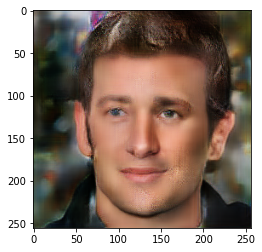

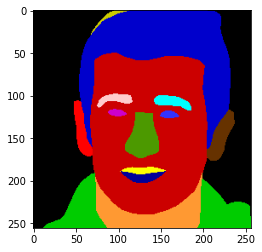

IMAGE!


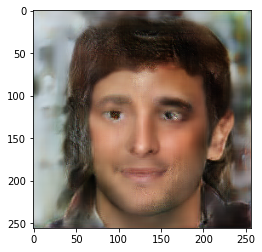

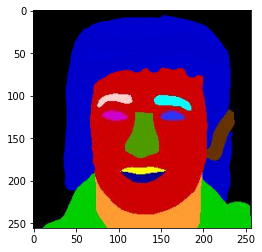

In [ ]:
test_mask_old = tf.expand_dims(mask_batch[1], axis=0)
test_image = tf.expand_dims(img_batch[1], axis=0)

out_mu, out_var = CelebAMask.encoder(test_image)
z_noise_style = CelebAMask.sampler((out_mu, out_var), train=True)
generated_image = CelebAMask.generator(test_mask_old, z_noise = z_noise_style)
print("IMAGE!")

omg_work = ((generated_image[0].numpy() + 1) * 127.5).astype(int)
plt.imshow(omg_work)
plt.show()

test_mask_ = ((test_mask[0].numpy() + 1) * 127.5).astype(int)
plt.imshow(test_mask_)
plt.show()




test_mask_old = tf.expand_dims(mask_batch[1], axis=0)
test_image = tf.expand_dims(img_batch[1], axis=0)

out_mu, out_var = CelebAMask.encoder(test_image)
z_noise_style = CelebAMask.sampler((out_mu, out_var), train=True)
generated_image = CelebAMask.generator(test_mask, z_noise = z_noise_style)
print("IMAGE!")

omg_work = ((generated_image[0].numpy() + 1) * 127.5).astype(int)
plt.imshow(omg_work)
plt.show()

test_mask_ = ((test_mask[0].numpy() + 1) * 127.5).astype(int)
plt.imshow(test_mask_)
plt.show()


In [ ]:
# out_mu

In [ ]:
for i, img in enumerate(data_set.batch(100).take(20)): 
  img_save = img['img_original']
  img_save = np.array(((img_save[0].numpy() + 1) * 127.5).astype(int), dtype="uint8")
  plt.imsave(f"/content/drive/MyDrive/KTH/Deep Learning in DS (DD2424)/Amazing-Landscapes/GAN_Metrics-Tensorflow/real_target/{i}.jpeg", img_save)

## Generate

In [ ]:
set_type = "500"
base_path = "DataSets/CelebAMask/processed_data"
reader = dp.DataReader(base_path, set_type, config_data_processing)

reader.read_data_set()
data_set = reader.get_dataset()

In [ ]:
for image in data_set.batch(100).take(30):
    mask_batch = image['img_masked']
    img_batch = image['img_original']
    label_batch = image['label']

    out_mu, out_var = CelebAMask.encoder(img_batch)
    z_noise_style = CelebAMask.sampler((out_mu, out_var))
    generated_images = CelebAMask.generator(mask_batch, z_noise = z_noise_style)

    for generated_image, label in zip(generated_images, label_batch):
        omg_work = np.array(((generated_image.numpy() + 1) * 127.5).astype(int), dtype="uint8")
        path =f"DataSets/generated_images/faces/val/{label.numpy().decode('utf-8')}.jpeg"
        plt.imsave(path, omg_work)